# **Steel Plate Defect Prediction 🗜️**
---

The dataset for the competition (both train and test) was generated from a deep learning model trained on the Steel Plates Faults dataset from UCI. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

**Files**:
* train.csv - the training dataset; there are 7 binary targets: Pastry, Z_Scratch, K_Scatch, Stains, Dirtiness, Bumps, Other_Faults
* test.csv - the test dataset; your objective is to predict the probability of each of the 7 binary targets
* sample_submission.csv - a sample submission file in the correct format

Source: [Competition Dataset Description](https://www.kaggle.com/competitions/playground-series-s4e3/data)

## **Data Preparation 📃**
---

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


## **Importing the Libraries and Dataset 📔**
---

In [2]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.multioutput import MultiOutputClassifier

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [3]:
# Load the dataset
train_df = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv', index_col='id')
test_df = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv', index_col='id')

# **Exploratory Data Analysis 🌆**
---

In [4]:
train_df.head().style.background_gradient(cmap='viridis')

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,584,590,909972,909977,16,8,5,2274,113,140,1358,0,1,50,0.739300,0.400000,0.500000,0.005900,1.000000,1.000000,0.000000,1.204100,0.903100,0.699000,-0.500000,-0.010400,0.141700,0,0,0,1,0,0,0
1,808,816,728350,728372,433,20,54,44478,70,111,1687,1,0,80,0.777200,0.287800,0.258100,0.004400,0.250000,1.000000,1.000000,2.636500,0.778200,1.732400,0.741900,-0.299700,0.949100,0,0,0,0,0,0,1
2,39,192,2212076,2212144,11388,705,420,1311391,29,141,1400,0,1,40,0.055700,0.528200,0.989500,0.107700,0.236300,0.385700,0.000000,4.056400,2.179000,2.209500,-0.010500,-0.094400,1.000000,0,0,1,0,0,0,0
3,781,789,3353146,3353173,210,16,29,3202,114,134,1387,0,1,40,0.720200,0.333300,0.333300,0.004400,0.375000,0.931000,1.000000,2.322200,0.778200,1.431400,0.666700,-0.040200,0.402500,0,0,1,0,0,0,0
4,1540,1560,618457,618502,521,72,67,48231,82,111,1692,0,1,300,0.121100,0.534700,0.084200,0.019200,0.210500,0.986100,1.000000,2.769400,1.415000,1.880800,0.915800,-0.245500,0.999800,0,0,0,0,0,0,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19219 entries, 0 to 19218
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              19219 non-null  int64  
 1   X_Maximum              19219 non-null  int64  
 2   Y_Minimum              19219 non-null  int64  
 3   Y_Maximum              19219 non-null  int64  
 4   Pixels_Areas           19219 non-null  int64  
 5   X_Perimeter            19219 non-null  int64  
 6   Y_Perimeter            19219 non-null  int64  
 7   Sum_of_Luminosity      19219 non-null  int64  
 8   Minimum_of_Luminosity  19219 non-null  int64  
 9   Maximum_of_Luminosity  19219 non-null  int64  
 10  Length_of_Conveyer     19219 non-null  int64  
 11  TypeOfSteel_A300       19219 non-null  int64  
 12  TypeOfSteel_A400       19219 non-null  int64  
 13  Steel_Plate_Thickness  19219 non-null  int64  
 14  Edges_Index            19219 non-null  float64
 15  Empty_I

In [6]:
train_df.describe().style.background_gradient(cmap='viridis')

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A300,TypeOfSteel_A400,Steel_Plate_Thickness,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
count,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000,19219.000000
mean,709.854675,753.857641,1849756.040012,1846605.345439,1683.987616,95.654665,64.124096,191846.678235,84.808419,128.647380,1459.350747,0.402674,0.596337,76.213122,0.352939,0.409309,0.574520,0.030609,0.614749,0.831652,0.591899,2.473475,1.312667,1.389737,0.102742,-0.138382,0.571902,0.076279,0.059837,0.178573,0.029554,0.025235,0.247828,0.341225
std,531.544189,499.836603,1903553.850679,1896295.137914,3730.319865,177.821382,101.054178,442024.694057,28.800344,14.196976,145.568687,0.490449,0.490644,53.931960,0.318976,0.124143,0.259436,0.047302,0.222391,0.220966,0.482050,0.760575,0.467848,0.405549,0.487681,0.120344,0.332219,0.265450,0.237190,0.383005,0.169358,0.156844,0.431762,0.474133
min,0.000000,4.000000,6712.000000,6724.000000,6.000000,2.000000,1.000000,250.000000,0.000000,39.000000,1227.000000,0.000000,0.000000,40.000000,0.000000,0.000000,0.008300,0.001500,0.014400,0.105000,0.000000,0.778200,0.301000,0.000000,-0.988400,-0.885000,0.119000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,49.000000,214.000000,657468.000000,657502.000000,89.000000,15.000000,14.000000,9848.000000,70.000000,124.000000,1358.000000,0.000000,0.000000,40.000000,0.058600,0.317500,0.375750,0.006600,0.451600,0.655200,0.000000,1.949400,1.000000,1.079200,-0.272700,-0.192500,0.253200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,777.000000,796.000000,1398169.000000,1398179.000000,168.000000,25.000000,23.000000,18238.000000,90.000000,127.000000,1364.000000,0.000000,1.000000,69.000000,0.238500,0.413500,0.545400,0.009500,0.636400,0.964300,1.000000,2.227900,1.146100,1.322200,0.111100,-0.142600,0.472900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1152.000000,1165.000000,2368032.000000,2362511.000000,653.000000,64.000000,61.000000,67978.000000,105.000000,135.000000,1652.000000,1.000000,1.000000,80.000000,0.656100,0.494600,0.818200,0.019100,0.785700,1.000000,1.000000,2.814900,1.431400,1.707600,0.529400,-0.084000,0.999400,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1705.000000,1713.000000,12987661.000000,12987692.000000,152655.000000,7553.000000,903.000000,11591414.000000,196.000000,253.000000,1794.000000,1.000000,1.000000,300.000000,0.995200,0.927500,1.000000,0.665100,1.000000,1.000000,1.000000,4.554300,2.997300,4.033300,0.991700,0.642100,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
describe = train_df.describe().T
describe['skew'] = train_df.skew().values
describe['kurtosis'] = train_df.kurt().values
describe = round(describe, 2)
describe.style.background_gradient(cmap='viridis')

,count,mean,std,min,25%,50%,75%,max,skew,kurtosis
X_Minimum,19219.000000,709.850000,531.540000,0.000000,49.000000,777.000000,1152.000000,1705.000000,0.020000,-1.330000
X_Maximum,19219.000000,753.860000,499.840000,4.000000,214.000000,796.000000,1165.000000,1713.000000,0.070000,-1.260000
Y_Minimum,19219.000000,1849756.040000,1903553.850000,6712.000000,657468.000000,1398169.000000,2368032.000000,12987661.000000,2.580000,8.870000
Y_Maximum,19219.000000,1846605.350000,1896295.140000,6724.000000,657502.000000,1398179.000000,2362511.000000,12987692.000000,2.570000,8.840000
Pixels_Areas,19219.000000,1683.990000,3730.320000,6.000000,89.000000,168.000000,653.000000,152655.000000,6.980000,181.740000
X_Perimeter,19219.000000,95.650000,177.820000,2.000000,15.000000,25.000000,64.000000,7553.000000,6.320000,167.410000
Y_Perimeter,19219.000000,64.120000,101.050000,1.000000,14.000000,23.000000,61.000000,903.000000,2.980000,9.290000
Sum_of_Luminosity,19219.000000,191846.680000,442024.690000,250.000000,9848.000000,18238.000000,67978.000000,11591414.000000,6.690000,121.210000
Minimum_of_Luminosity,19219.000000,84.810000,28.800000,0.000000,70.000000,90.000000,105.000000,196.000000,-0.330000,-0.000000
Maximum_of_Luminosity,19219.000000,128.650000,14.200000,39.000000,124.000000,127.000000,135.000000,253.000000,1.170000,9.780000


## **Data Cleaning 🫧**
---

In [8]:
# Check for duplicates
train_df.duplicated().sum()

0

In [9]:
# Check for missing values
train_df.isna().sum()

X_Minimum                0
X_Maximum                0
Y_Minimum                0
Y_Maximum                0
Pixels_Areas             0
X_Perimeter              0
Y_Perimeter              0
Sum_of_Luminosity        0
Minimum_of_Luminosity    0
Maximum_of_Luminosity    0
Length_of_Conveyer       0
TypeOfSteel_A300         0
TypeOfSteel_A400         0
Steel_Plate_Thickness    0
Edges_Index              0
Empty_Index              0
Square_Index             0
Outside_X_Index          0
Edges_X_Index            0
Edges_Y_Index            0
Outside_Global_Index     0
LogOfAreas               0
Log_X_Index              0
Log_Y_Index              0
Orientation_Index        0
Luminosity_Index         0
SigmoidOfAreas           0
Pastry                   0
Z_Scratch                0
K_Scatch                 0
Stains                   0
Dirtiness                0
Bumps                    0
Other_Faults             0
dtype: int64

In [10]:
# Return the number of unique values for each column
train_df.nunique()

X_Minimum                1191
X_Maximum                1259
Y_Minimum                3345
Y_Maximum                3341
Pixels_Areas             1154
X_Perimeter               460
Y_Perimeter               331
Sum_of_Luminosity        2595
Minimum_of_Luminosity     162
Maximum_of_Luminosity      98
Length_of_Conveyer         99
TypeOfSteel_A300            2
TypeOfSteel_A400            2
Steel_Plate_Thickness      27
Edges_Index              1849
Empty_Index              1748
Square_Index             1118
Outside_X_Index           525
Edges_X_Index            1102
Edges_Y_Index             900
Outside_Global_Index        4
LogOfAreas               1072
Log_X_Index               206
Log_Y_Index               241
Orientation_Index        1598
Luminosity_Index         2046
SigmoidOfAreas            467
Pastry                      2
Z_Scratch                   2
K_Scatch                    2
Stains                      2
Dirtiness                   2
Bumps                       2
Other_Faul

## **Inspecting the Features 🕵🏻**
---

<Figure size 2000x2000 with 0 Axes>

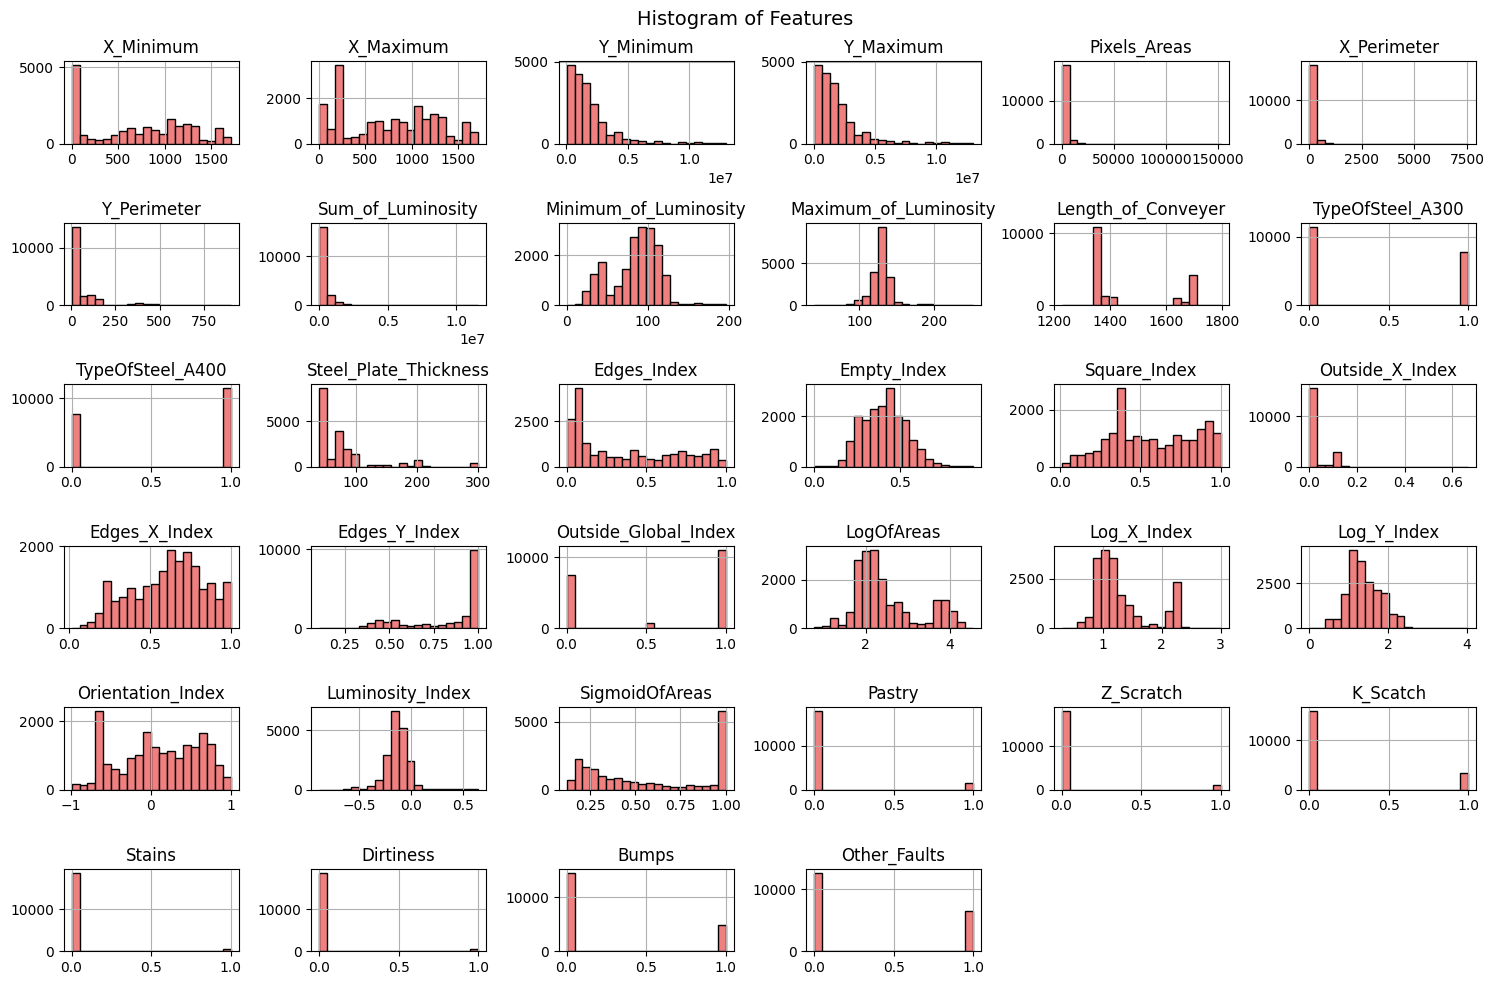

In [11]:
plt.figure(figsize=(20,20), facecolor='lightgrey')
train_df.hist(bins=20, figsize=(15, 10), color='lightcoral', edgecolor='black', grid=True)
plt.suptitle('Histogram of Features', fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 2000x2000 with 0 Axes>

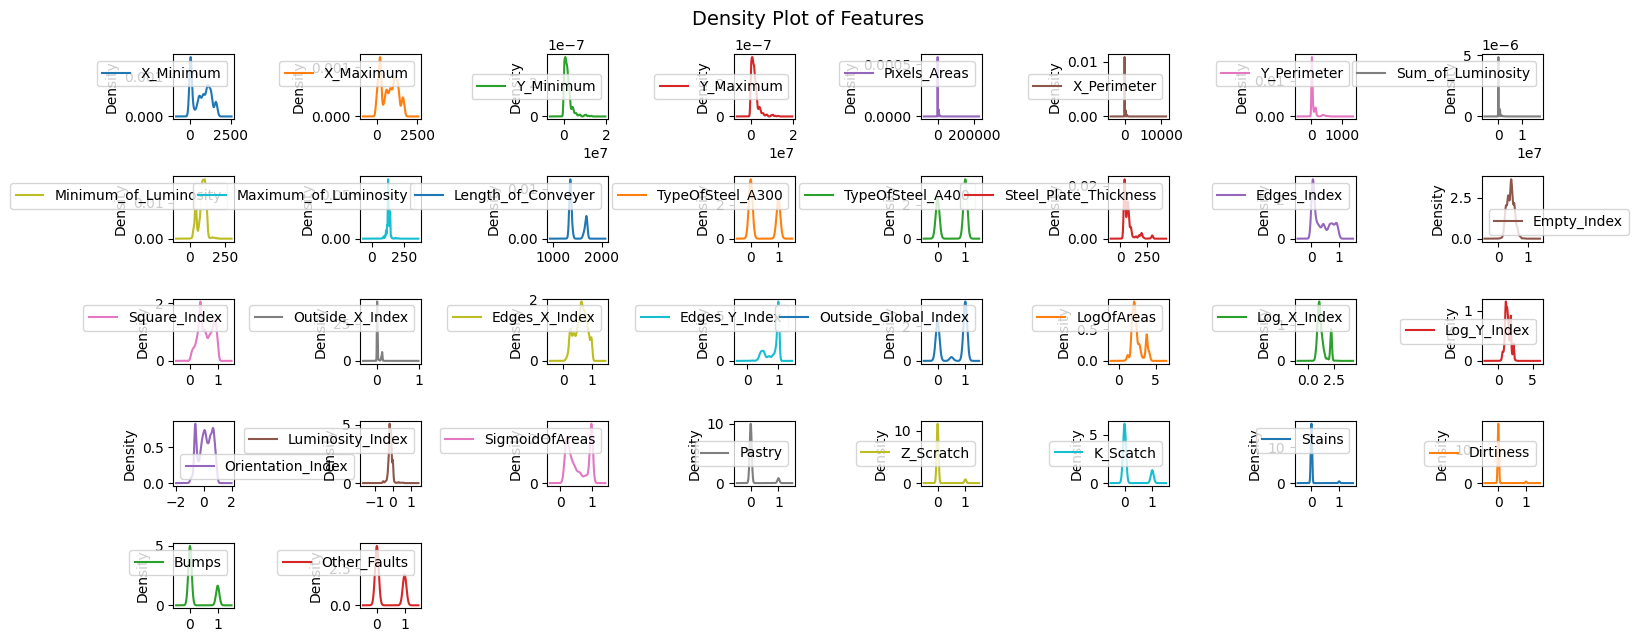

In [12]:
plt.figure(figsize=(20,20), facecolor='lightgrey')
train_df.plot(kind="density", layout=(8,8), subplots=True, sharex=False, sharey=False, figsize=(15,10))
plt.suptitle('Density Plot of Features', fontsize=14)
plt.tight_layout()
plt.show()

<Figure size 2000x2000 with 0 Axes>

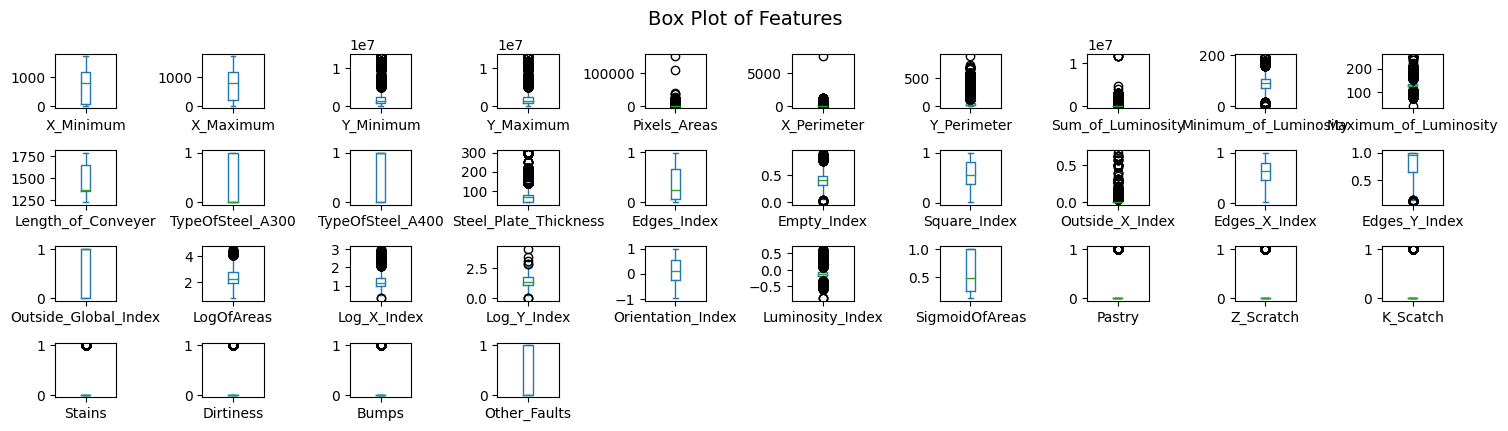

In [13]:
plt.figure(figsize=(20,20), facecolor='lightgrey')
train_df.plot(kind="box", layout=(10,10), subplots=True, sharex=False, sharey=False, figsize=(15,10))
plt.suptitle('Box Plot of Features', fontsize=14)
plt.tight_layout()
plt.show()

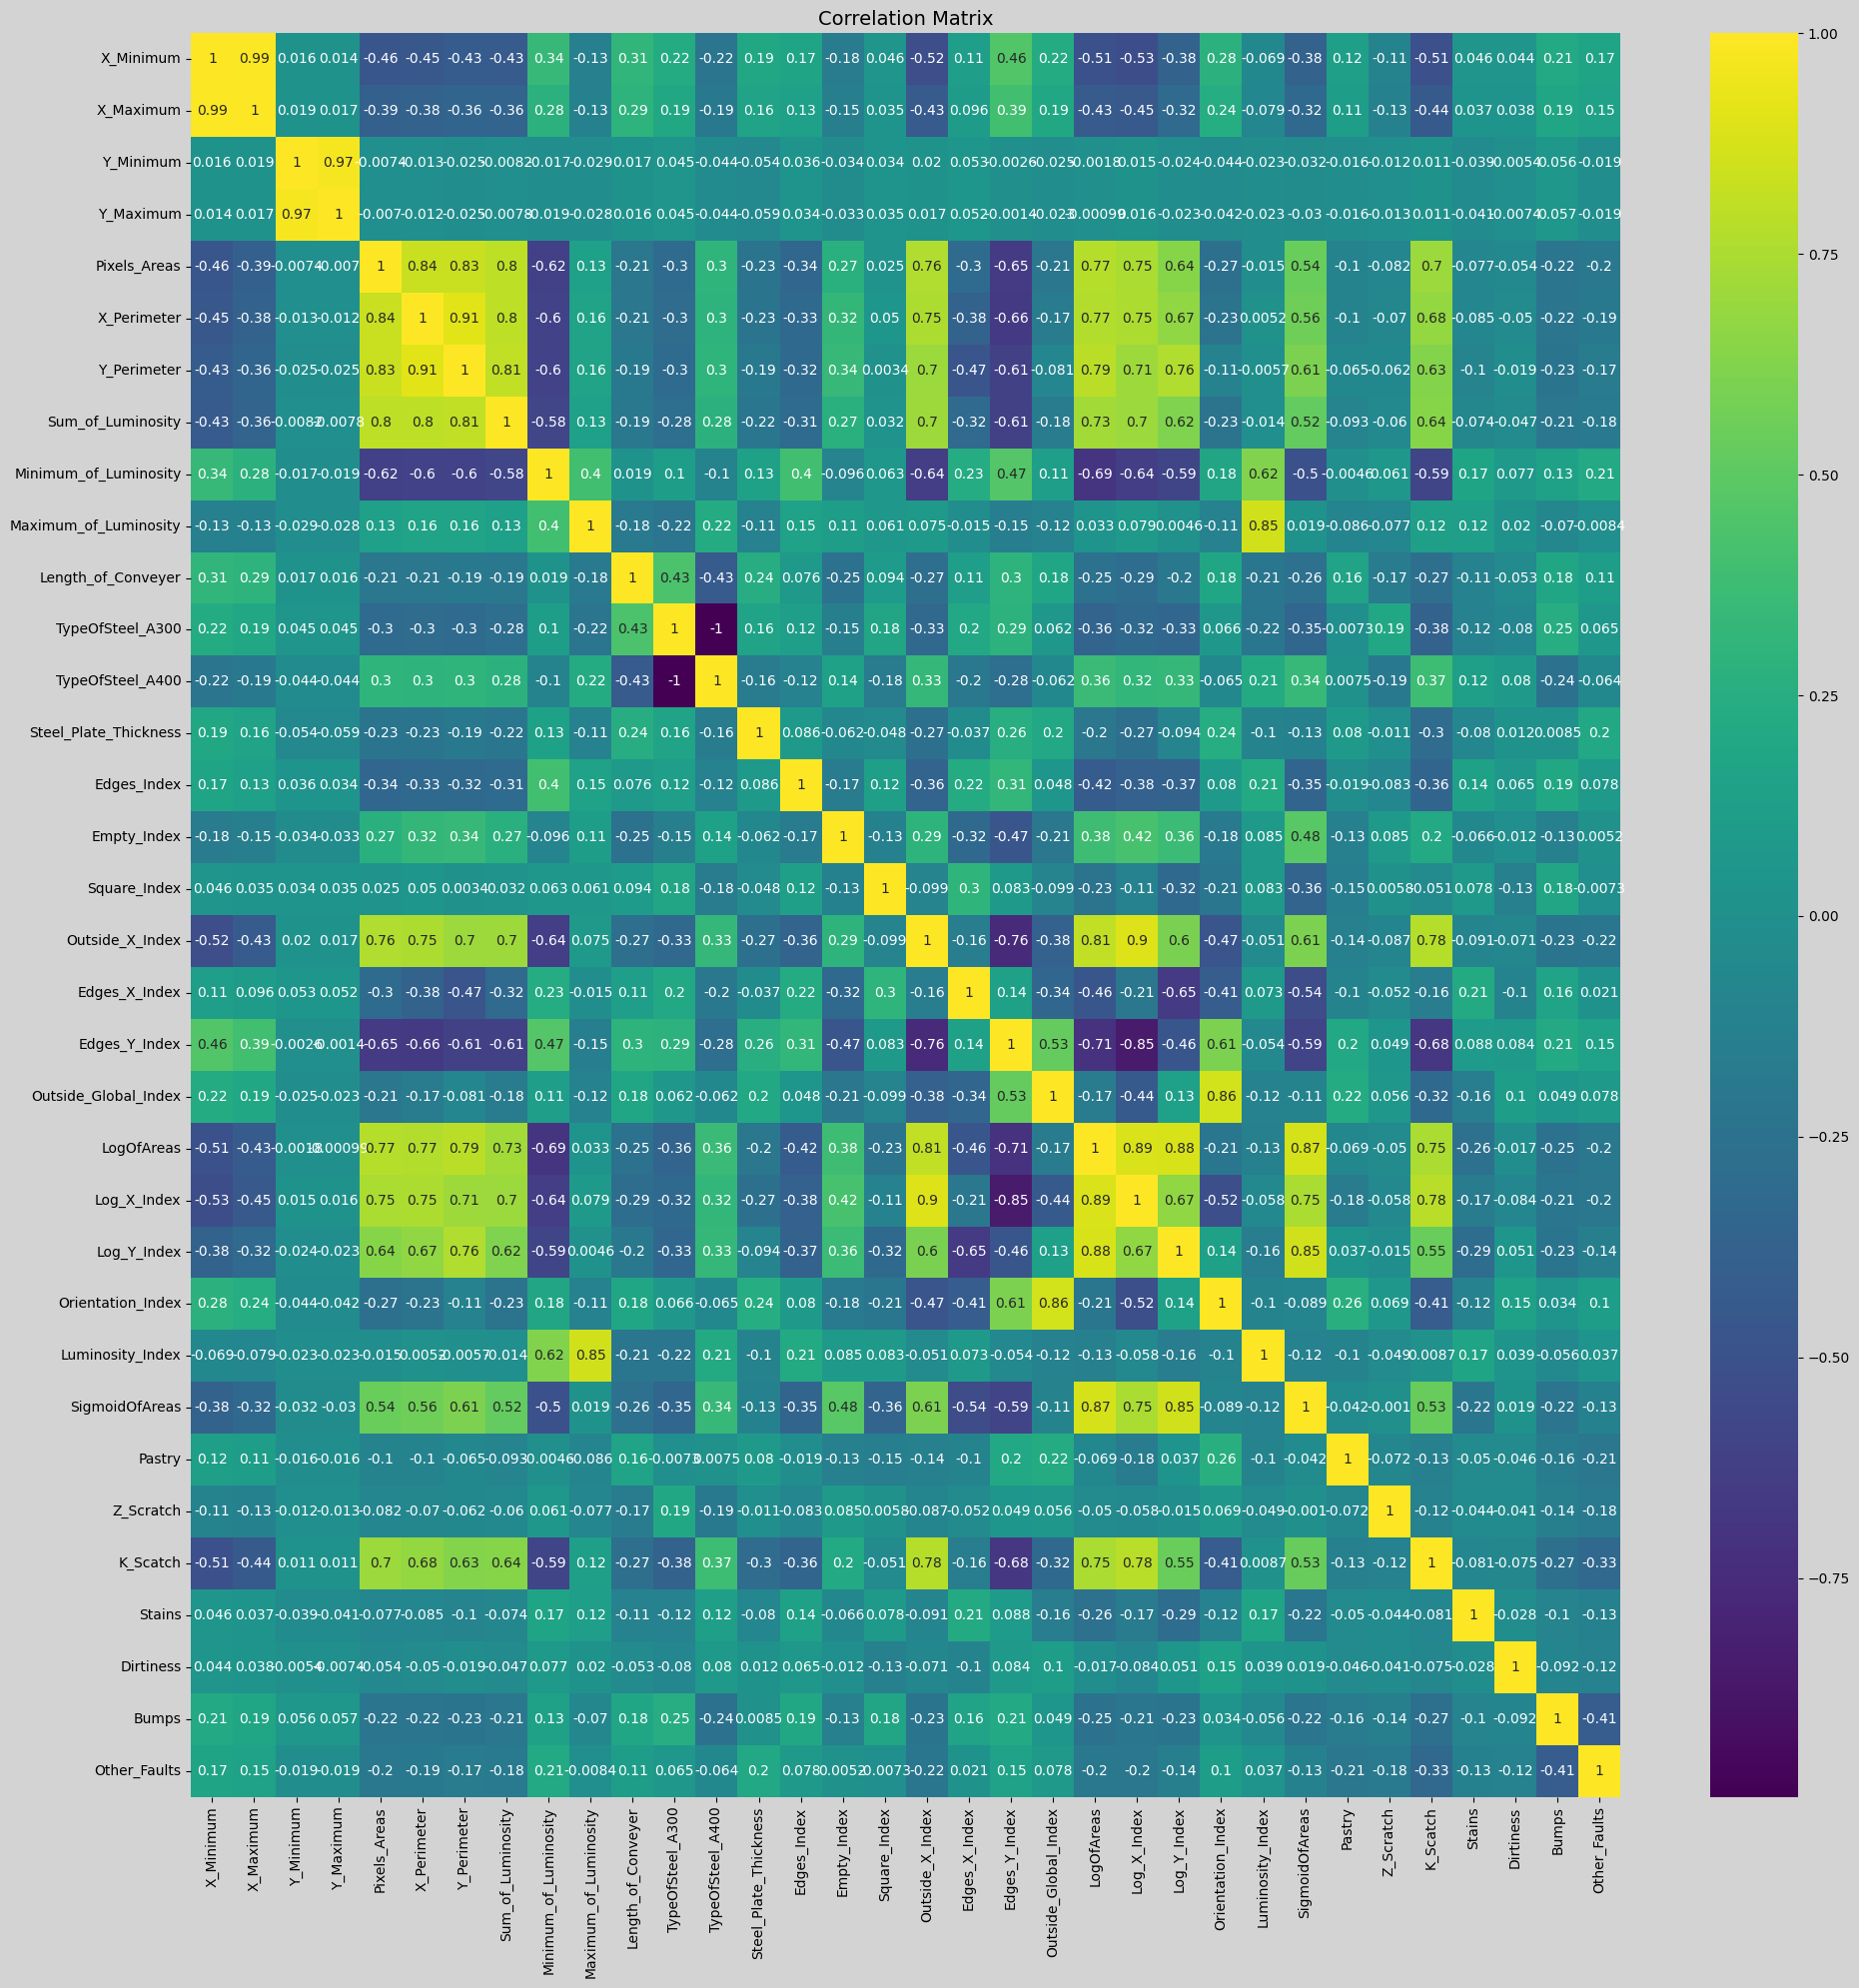

In [14]:
corr = train_df.corr(method='pearson')

plt.figure(figsize=(20, 20), facecolor='lightgrey')
plt.rcParams['figure.facecolor'] = 'lightgrey'
s = sns.heatmap(corr, annot=True, cmap='viridis')
plt.title("Correlation Matrix", fontsize=14)
plt.tight_layout()
plt.show()

## **Target Class Analysis 🎯**
---

In [15]:
target_classes = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]
targets_df = train_df[target_classes]
targets_df
# train = train.drop(target_classes, axis="columns")

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1
2,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...
19214,0,0,0,1,0,0,0
19215,0,0,0,0,0,0,1
19216,1,0,0,0,0,0,0


In [16]:
targets_df.sum(axis=0)

Pastry          1466
Z_Scratch       1150
K_Scatch        3432
Stains           568
Dirtiness        485
Bumps           4763
Other_Faults    6558
dtype: int64

* The sum of values for the "Pastry" column is 1466.
* The sum of values for the "Z_Scratch" column is 1150.
* The sum of values for the "K_Scatch" column is 3432.
* The sum of values for the "Stains" column is 568.
* The sum of values for the "Dirtiness" column is 485.
* The sum of values for the "Bumps" column is 4763.
* The sum of values for the "Other_Faults" column is 6558.

In [17]:
targets_df.sum(axis=1).value_counts()

1    18380
0      818
2       21
Name: count, dtype: int64

* There are 18380 rows where the sum of values across the row is 1.
* There are 818 rows where the sum of values across the row is 0.
* There are 21 rows where the sum of values across the row is 2.

In [18]:
targets_df[targets_df.sum(axis=1)==0]

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
8,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0
50,0,0,0,0,0,0,0
73,0,0,0,0,0,0,0
93,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...
19185,0,0,0,0,0,0,0
19189,0,0,0,0,0,0,0
19191,0,0,0,0,0,0,0


In [19]:
targets_df[targets_df.sum(axis=1)==2]

,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
id,,,,,,,
634,0,0,1,0,0,0,1
752,0,0,1,0,0,0,1
3572,0,0,1,0,0,1,0
4416,0,0,1,0,0,0,1
4530,0,0,1,0,0,0,1
4664,0,0,1,0,0,0,1
6448,0,0,1,0,0,0,1
7589,0,0,1,0,0,0,1
8075,0,0,1,0,0,0,1


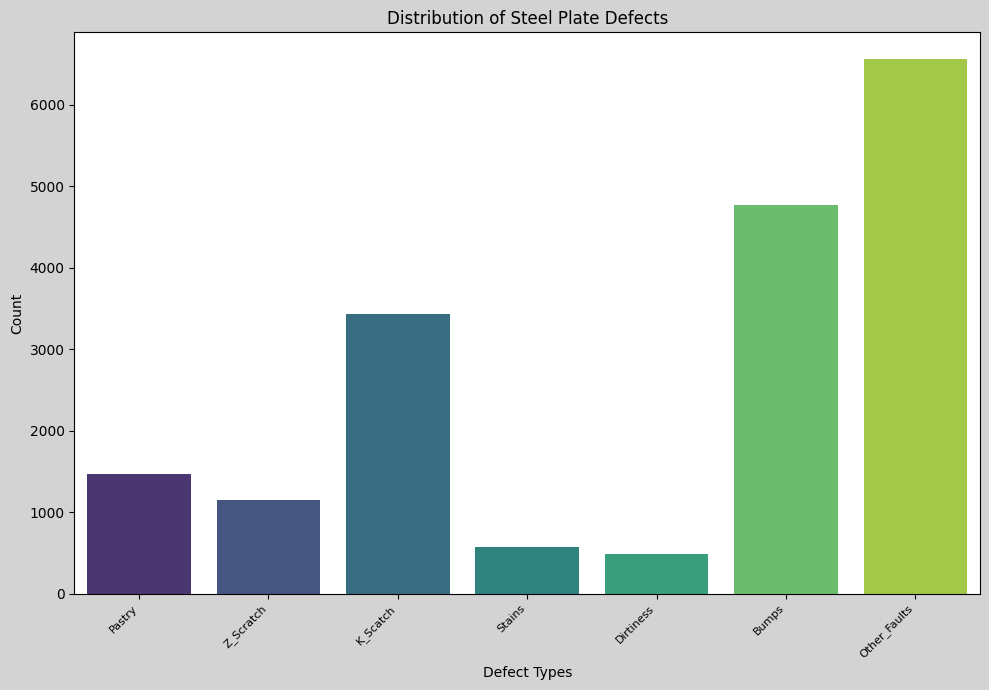

In [20]:
color_list = ["#A5D7E8", "#576CBC", "#19376D", "#0B2447"]
cmap_custom = ListedColormap(color_list)

# Sum the values in each column
defect_counts = targets_df.sum()

# Plot the counts
plt.figure(figsize=(10, 7), facecolor='lightgrey')
ax = sns.barplot(x=defect_counts.index, y=defect_counts.values, palette='viridis')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=8)
plt.title('Distribution of Steel Plate Defects')
plt.xlabel('Defect Types')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [21]:
# Drop the rows that contain two targets
rows_to_drop = targets_df[targets_df.sum(axis=1)==2].index

# Drop rows from train_df based on the identified rows
# train_df = train_df.drop(index=rows_to_drop)

In [22]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19219 entries, 0 to 19218
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   X_Minimum              19219 non-null  int64  
 1   X_Maximum              19219 non-null  int64  
 2   Y_Minimum              19219 non-null  int64  
 3   Y_Maximum              19219 non-null  int64  
 4   Pixels_Areas           19219 non-null  int64  
 5   X_Perimeter            19219 non-null  int64  
 6   Y_Perimeter            19219 non-null  int64  
 7   Sum_of_Luminosity      19219 non-null  int64  
 8   Minimum_of_Luminosity  19219 non-null  int64  
 9   Maximum_of_Luminosity  19219 non-null  int64  
 10  Length_of_Conveyer     19219 non-null  int64  
 11  TypeOfSteel_A300       19219 non-null  int64  
 12  TypeOfSteel_A400       19219 non-null  int64  
 13  Steel_Plate_Thickness  19219 non-null  int64  
 14  Edges_Index            19219 non-null  float64
 15  Empty_I

# **Distribution Pairs 🎎**
---

In [23]:
color_list = ["#FF5733", "#33FF57", "#3333FF", "#FFFF33"]
cmap_custom = ListedColormap(color_list)

def plot_distribution_pairs(train, test, feature, hue="set", palette=None):
    data_df = train.copy()
    data_df['set'] = 'train'
    data_df = pd.concat([data_df, test.copy()]).fillna('test')
    data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

    f, axes = plt.subplots(1, 2, figsize=(14, 6))
    for i, s in enumerate(data_df[hue].unique()):
        selection = data_df.loc[data_df[hue]==s, feature]
        # Filter 'selection' to include only the central 95% of the data
        q_025, q_975 = np.percentile(selection, [2.5, 97.5])
        selection_filtered = selection[(selection >= q_025) & (selection <= q_975)]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", category=FutureWarning)
            sns.histplot(selection_filtered, color=palette[i], ax=axes[0], label=s)
            sns.boxplot(x=hue, y=feature, data=data_df, palette=palette, ax=axes[1])
    axes[0].set_title(f"Paired train/test distributions of {feature}")
    axes[1].set_title(f"Paired train/test boxplots of {feature}")
    axes[0].legend()
    axes[1].legend()
    plt.show()

train = train_df.copy() 
test = test_df.copy()

train = train.drop(columns=target_classes)

# for feature in train.columns:
#     plot_distribution_pairs(train, test, feature, palette=color_list)

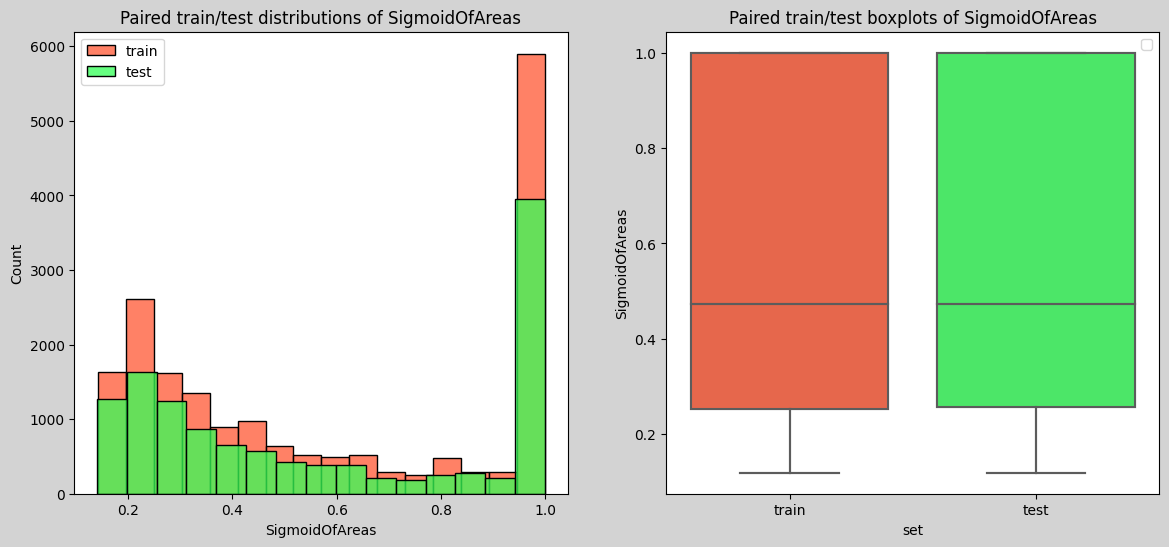

In [24]:
plot_distribution_pairs(train, test, feature="SigmoidOfAreas", palette=color_list)

# **Data Preprocessing ⚙️**
---

In [25]:
target_classes = ["Pastry", "Z_Scratch", "K_Scatch", "Stains", "Dirtiness", "Bumps", "Other_Faults"]

X = train_df.drop(columns=target_classes)
y = train_df[target_classes]

# Define preprocessing steps for numerical and categorical columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classifier = RandomForestClassifier(n_estimators=300, max_depth=20)

# Create a pipeline with preprocessing and RandomForestClassifier
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('classifier', MultiOutputClassifier(classifier))])

In [26]:
classifiers = {
    'CatBoost': CatBoostClassifier(eval_metric='Accuracy',
                                   random_seed=56,    
                                   iterations=2000,
                                   verbose=False),
    'XGBoost': XGBClassifier(learning_rate=0.01, 
                             n_estimators=5000, 
                             random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, solver='lbfgs'),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=700,
                                                    random_state=77,
                                                    criterion='entropy',    
                                                    max_depth=20,
                                                    class_weight='balanced'),
    'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
    'MLPClassifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000),
}

performance_list = []

In [27]:
# Train and evaluate models
for name, classifier in tqdm(classifiers.items(), desc='Training models', unit='model'):
    model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', MultiOutputClassifier(classifier))])
    model.fit(X_train, y_train)

    test_predictions = model.predict(X_test)

    accuracy = accuracy_score(y_test, test_predictions)
    classification_rep = classification_report(y_test, test_predictions, zero_division=1)

    performance_list.append({
        'Model': name,
        'Accuracy': accuracy,
        'Classification Report': classification_rep
    })

    print(f"Model: {name}")
    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(classification_rep)
    print("="*54)

Training models:  17%|█▋        | 1/6 [01:48<09:04, 108.83s/model]

Model: CatBoost
Accuracy: 0.42117585848074923
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.10      0.17       301
           1       0.62      0.53      0.57       220
           2       0.90      0.90      0.90       682
           3       0.62      0.76      0.68       100
           4       0.63      0.14      0.23        85
           5       0.55      0.35      0.43       926
           6       0.59      0.28      0.38      1349

   micro avg       0.67      0.42      0.52      3663
   macro avg       0.63      0.44      0.48      3663
weighted avg       0.64      0.42      0.49      3663
 samples avg       0.81      0.45      0.43      3663



Training models:  33%|███▎      | 2/6 [03:37<07:16, 109.02s/model]

Model: XGBoost
Accuracy: 0.4287200832466181
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.13      0.21       301
           1       0.62      0.52      0.56       220
           2       0.90      0.90      0.90       682
           3       0.63      0.76      0.69       100
           4       0.65      0.15      0.25        85
           5       0.53      0.36      0.43       926
           6       0.54      0.33      0.41      1349

   micro avg       0.65      0.45      0.53      3663
   macro avg       0.63      0.45      0.49      3663
weighted avg       0.62      0.45      0.50      3663
 samples avg       0.78      0.47      0.44      3663



Training models:  50%|█████     | 3/6 [03:39<03:00, 60.05s/model] 

Model: Logistic Regression
Accuracy: 0.3394901144640999
Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.06      0.11       301
           1       0.61      0.31      0.41       220
           2       0.90      0.89      0.89       682
           3       0.62      0.68      0.65       100
           4       0.00      0.00      0.00        85
           5       0.54      0.22      0.32       926
           6       0.58      0.17      0.26      1349

   micro avg       0.70      0.33      0.45      3663
   macro avg       0.54      0.33      0.38      3663
weighted avg       0.61      0.33      0.39      3663
 samples avg       0.87      0.36      0.34      3663



Training models:  67%|██████▋   | 4/6 [06:56<03:48, 114.16s/model]

Model: RandomForestClassifier
Accuracy: 0.4323621227887617
Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.14      0.22       301
           1       0.60      0.50      0.54       220
           2       0.91      0.90      0.90       682
           3       0.61      0.68      0.64       100
           4       0.42      0.09      0.15        85
           5       0.52      0.43      0.47       926
           6       0.55      0.34      0.42      1349

   micro avg       0.64      0.46      0.54      3663
   macro avg       0.59      0.44      0.48      3663
weighted avg       0.61      0.46      0.51      3663
 samples avg       0.77      0.49      0.45      3663



Training models:  83%|████████▎ | 5/6 [06:59<01:13, 73.80s/model] 

Model: DecisionTreeClassifier
Accuracy: 0.32596253902185224
Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.24      0.23       301
           1       0.38      0.43      0.40       220
           2       0.82      0.85      0.83       682
           3       0.55      0.63      0.59       100
           4       0.12      0.16      0.14        85
           5       0.41      0.42      0.42       926
           6       0.45      0.44      0.44      1349

   micro avg       0.48      0.49      0.48      3663
   macro avg       0.42      0.45      0.44      3663
weighted avg       0.48      0.49      0.49      3663
 samples avg       0.64      0.52      0.43      3663



Training models: 100%|██████████| 6/6 [12:22<00:00, 123.73s/model]

Model: MLPClassifier
Accuracy: 0.39490114464099896
Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.19      0.26       301
           1       0.51      0.37      0.43       220
           2       0.88      0.88      0.88       682
           3       0.57      0.67      0.62       100
           4       0.24      0.14      0.18        85
           5       0.46      0.36      0.40       926
           6       0.51      0.31      0.39      1349

   micro avg       0.58      0.43      0.49      3663
   macro avg       0.51      0.42      0.45      3663
weighted avg       0.55      0.43      0.48      3663
 samples avg       0.73      0.46      0.42      3663



In [28]:
performance_df = pd.DataFrame(performance_list)
performance_df['Rank'] = performance_df['Accuracy'].rank(ascending=False, method='first').astype(int)
performance_df = performance_df.sort_values(by='Rank')
best_model_performance = performance_df.iloc[0]['Model']
performance_df[['Model', 'Accuracy', 'Rank']].style.background_gradient(cmap='viridis')

,Model,Accuracy,Rank
3,RandomForestClassifier,0.432362,1
1,XGBoost,0.428720,2
0,CatBoost,0.421176,3
5,MLPClassifier,0.394901,4
2,Logistic Regression,0.339490,5
4,DecisionTreeClassifier,0.325963,6


In [29]:
best_model = classifiers[best_model_performance]
best_model

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=20, n_estimators=700, random_state=77)

In [30]:
final_model = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_model)])
final_model.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  Index(['X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum', 'Pixels_Areas',
       'X_Perimeter', 'Y_Perimeter', 'Sum_of_Luminosity',
       'Minimum_of_Luminosity', 'Maximum_of_Luminosity', 'Length_of_Conveyer',
       'TypeOfSteel_A300', 'TypeOfSteel_A400', 'Steel_P...
       'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index',
       'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index', 'LogOfAreas',
       'Log_X_Index', 'Log_Y_Index', 'Orientation_Index', 'Luminosity_Index',
       'SigmoidOfAreas'],
      dtype='object'))])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=20,
                                        n_estimators=700, random_state=77))])

# **Submit the Prediction 🚀**
---

In [31]:
final_pred = final_model.predict(test_df)

In [32]:
result_df = pd.DataFrame(final_pred, columns=y.keys())
result_df.insert(0, 'id', test_df.index) 
result_df

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0,0,0,0,0,0,0
1,19220,0,0,0,0,0,0,0
2,19221,0,0,0,0,0,0,0
3,19222,0,0,0,0,0,0,0
4,19223,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
12809,32028,0,0,0,0,0,0,0
12810,32029,0,0,0,0,0,0,0
12811,32030,0,0,1,0,0,0,0
12812,32031,0,0,0,0,0,0,0


In [33]:
result_df.to_csv('my_submission.csv', index=False)

# **References**
---
* [Steel Plate Defect Prediction Dataset](https://www.kaggle.com/competitions/playground-series-s4e3/datahttps://www.kaggle.com/competitions/playground-series-s4e3)
* [Steel Plate EDA XGBoostis all you need](https://www.kaggle.com/code/lucamassaron/steel-plate-eda-xgboost-is-all-you-need)
* [Kapturov's Solution of PS S4E3](https://www.kaggle.com/code/kapturovalexander/kapturov-s-solution-of-ps-s4e3)
* [Seven Targets TF Decision Forests](https://www.kaggle.com/code/mpwolke/seven-targets-tf-decision-forests)
* [Simple Defect Prediction](https://www.kaggle.com/code/najeebz/simple-defect-prediction-xgboost-machine-learning)